In [23]:
# Author: Alexandre Gramfort <alexandre.gramfort@inria.fr>
#         Albert Thomas <albert.thomas@telecom-paristech.fr>
# License: BSD 3 clause

import time, talib, os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.datasets import make_moons, make_blobs
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
print(__doc__)
matplotlib.rcParams['contour.negative_linestyle'] = 'solid'
import matplotlib.pyplot as plt

#plt.plot(volume_mean, 'g-')
#plt.show()


fig, ax = plt.subplots()
ax.plot(price, 'b-')
ax.set_xlabel('Price')
ax.set_ylabel('close', color='b')
plt.show()



In [24]:
filepath = '/home/lir0b/data/TradingData/BinanceKline/BTCUSDT'
filename = 'Binance-BTCUSDT-1m-1-Jan-2018-1-Feb-2018-kline.xlsx'
datadf = pd.read_excel(os.path.join(filepath, filename))

In [25]:
# kline feature
open_price = datadf['Open'].to_numpy()
close_price = datadf['Close'].to_numpy()
high_price = datadf['High'].to_numpy()
low_price = datadf['Low'].to_numpy()
volume = datadf['Volume'].to_numpy()
volume_local_mean = np.array([np.mean(volume[max(int(i/60)*60-360, 0):max(int(i/60)*60-300, 0)]) for i in range(len(volume))])
volume_mean = np.array([np.mean(volume[max(int(i/60)*60-60, 0):max(int(i/60)*60, 0)]) for i in range(len(volume))])
volume_norm = volume / volume_mean
open_time = datadf['OpenTime'].to_numpy()

In [26]:
# calc feature per kline
close_open = (close_price-open_price)/open_price
high_low = (high_price-low_price)/open_price
high_close = (high_price-close_price)/open_price
close_low = (close_price-low_price)/open_price
#volume_mean = volume / np.mean(volume)

In [27]:
data_kline_feat = np.vstack([close_open, high_low, high_close, close_low, volume])
data_kline_feat = data_kline_feat.T
data_kline_feat.shape
n = data_kline_feat.shape[0]
data_kline_feat0 = np.vstack([data_kline_feat[0, :], data_kline_feat[0, :], data_kline_feat])
data_kline_feat1 = np.vstack([data_kline_feat[0, :], data_kline_feat])
#data_kline_feat2 = np.vstack([data_kline_feat[0, :], data_kline_feat])
data_kline_group_feat = np.hstack([data_kline_feat0[0:-2, :], data_kline_feat1[0:-1, :], data_kline_feat])
data_kline_feat
datasets = [data_kline_feat]
#datasets = [data_kline_group_feat[0:5000, :]]
train_datasets = []

(44516, 5)

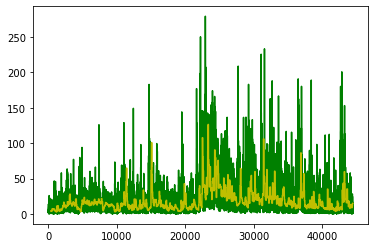

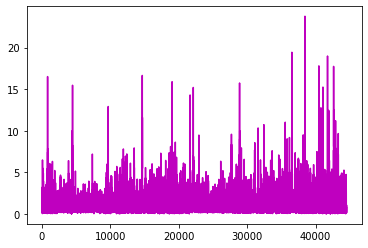

In [34]:
import matplotlib.pyplot as plt
#volume_mean = np.array([np.mean(volume[max(i-120, 0):i]) for i in range(len(volume))])
plt.plot(volume, 'g-')
plt.plot(volume_local_mean, 'y-')
plt.show()

plt.plot(volume_norm, 'm-')
plt.show()

In [36]:
# Example settings
data = datasets[0]
n_samples = len(data)
outliers_fraction = 0.05
n_outliers = int(outliers_fraction * n_samples)
n_inliers = n_samples - n_outliers

# define outlier/anomaly detection methods to be compared
anomaly_algorithms = [
    #("Robust covariance", EllipticEnvelope(contamination=outliers_fraction)),
    ("One-Class SVM", svm.OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma='scale')),
    #("Isolation Forest", IsolationForest(contamination=outliers_fraction, random_state=42)),
    #("Local Outlier Factor", LocalOutlierFactor(n_neighbors=35, contamination=outliers_fraction))
]

# Define datasets
#blobs_params = dict(random_state=0, n_samples=n_inliers, n_features=2)
'''
datasets = [
    make_blobs(centers=[[0, 0], [0, 0]], cluster_std=0.5, **blobs_params)[0],
    make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[0.5, 0.5], **blobs_params)[0],
    make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[1.5, .3], **blobs_params)[0],
    4. * (make_moons(n_samples=n_samples, noise=.05, random_state=0)[0] - np.array([0.5, 0.25])),
    14. * (np.random.RandomState(42).rand(n_samples, 2) - 0.5)
]
'''

'\ndatasets = [\n    make_blobs(centers=[[0, 0], [0, 0]], cluster_std=0.5, **blobs_params)[0],\n    make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[0.5, 0.5], **blobs_params)[0],\n    make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[1.5, .3], **blobs_params)[0],\n    4. * (make_moons(n_samples=n_samples, noise=.05, random_state=0)[0] - np.array([0.5, 0.25])),\n    14. * (np.random.RandomState(42).rand(n_samples, 2) - 0.5)\n]\n'

In [230]:
for i_dataset, X in enumerate(datasets):
    # Add outliers
    #X = np.concatenate([X, rng.uniform(low=-6, high=6, size=(n_outliers, data_kline_feat.shape[1]))], axis=0)
    for name, algorithm in anomaly_algorithms:
        t0 = time.time()
        #algorithm.fit(X)
        clf = algorithm.fit(X)
        t1 = time.time()
        # fit the data and tag outliers
        #if name == "Local Outlier Factor":
        #    y_pred = algorithm.fit_predict(X)
        #else:
        #    y_pred = algorithm.fit(X).predict(X)
        y_pred = clf.predict(X)
        print(X[y_pred!=1])

        # plot the levels lines and the points
        '''
        if name != "Local Outlier Factor":  # LOF does not implement predict
            Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='black')

        colors = np.array(['#377eb8', '#ff7f00'])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[(y_pred + 1) // 2])

        plt.xlim(-7, 7)
        plt.ylim(-7, 7)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1
        '''

[[-2.19606484e-03  2.36576402e-03  2.35573959e-03  1.00244238e-05
   9.96853000e-01]
 [-2.75907452e-03  2.75907452e-03  2.75907452e-03  0.00000000e+00
   5.94584000e-01]
 [ 2.15362527e-06  1.77243360e-03  6.86288586e-04  1.08614501e-03
   1.24413000e+00]
 ...
 [-1.96850394e-04  1.96850394e-04  1.96850394e-04  0.00000000e+00
   1.04280800e+00]
 [ 1.95712038e-04  2.06530291e-03  9.93312352e-05  1.96597168e-03
   9.64327000e-01]
 [-4.49876137e-04  8.35905223e-04  8.35905223e-04  0.00000000e+00
   6.85779000e-01]]


In [16]:
spread_vol = (close_price-open_price)/open_price*volume_norm
spread_sum = (close_price-open_price)/open_price

n = len(spread_vol)
spread_vol_20_3 = np.array([np.sum(spread_vol[max(i-20, 0): max(i-3, 0)]) for i in range(n)])
spread_vol_3_0 = np.array([np.sum(spread_vol[max(i-3, 0): max(i, 0)]) for i in range(n)])
spread_vol_5_0 = np.array([np.sum(spread_vol[max(i-5, 0): max(i, 0)]) for i in range(n)])
spread_vol_10_0 = np.array([np.sum(spread_vol[max(i-10, 0): max(i, 0)]) for i in range(n)])
spread_vol_20_0 = np.array([np.sum(spread_vol[max(i-20, 0): max(i, 0)]) for i in range(n)])

spread_20_3 = np.array([np.sum(spread_sum[max(i-20, 0): max(i-3, 0)]) for i in range(n)])
spread_3_0 = np.array([np.sum(spread_sum[max(i-3, 0): max(i, 0)]) for i in range(n)])
spread_5_0 = np.array([np.sum(spread_sum[max(i-5, 0): max(i, 0)]) for i in range(n)])
spread_10_0 = np.array([np.sum(spread_sum[max(i-10, 0): max(i, 0)]) for i in range(n)])
spread_20_0 = np.array([np.sum(spread_vol[max(i-20, 0): max(i, 0)]) for i in range(n)])

In [17]:
'''
price_dist = []
total_price_vol = 0
for i in range(n):
    total_price_vol += close_price[i]*volume[i]
    price_dist.append(total_price_vol)
for i in range(n):
    si = max(i-180, 0)
    total_price_vol = np.sum([close_price[t]*volume[t] for t in range(si, i)])
    less_price_vol = np.sum([close_price[t]*volume[t] for t in range(si, i) if close_price[t] < close_price[i]]) 
    price_ratio = less_price_vol / total_price_vol
    price_dist.append(price_dist)
price_dist = np.array(price_dist)
'''


'\nprice_dist = []\ntotal_price_vol = 0\nfor i in range(n):\n    total_price_vol += close_price[i]*volume[i]\n    price_dist.append(total_price_vol)\nfor i in range(n):\n    si = max(i-180, 0)\n    total_price_vol = np.sum([close_price[t]*volume[t] for t in range(si, i)])\n    less_price_vol = np.sum([close_price[t]*volume[t] for t in range(si, i) if close_price[t] < close_price[i]]) \n    price_ratio = less_price_vol / total_price_vol\n    price_dist.append(price_dist)\nprice_dist = np.array(price_dist)\n'

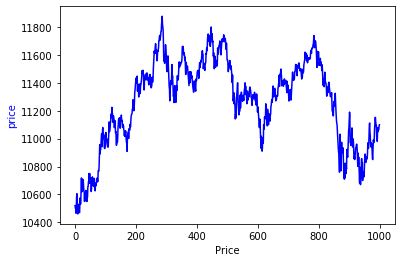

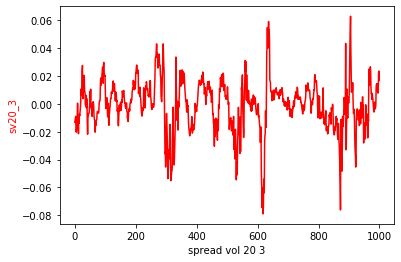

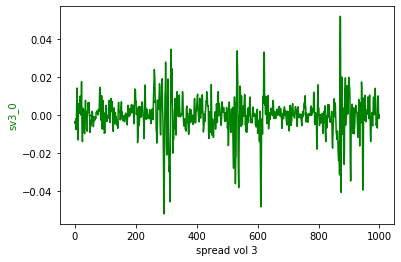

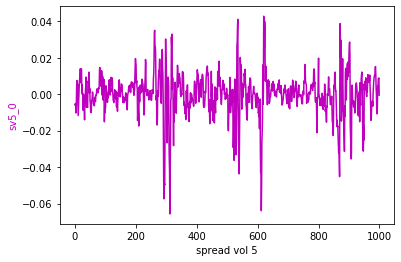

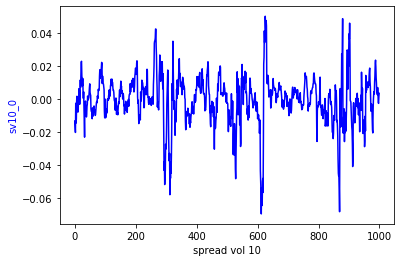

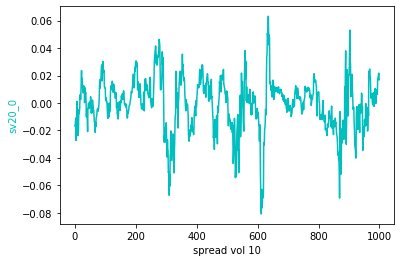

In [20]:
s1 = 25000
s2 = s1 + 1000

# spread vol feature 
sv20_3 = spread_vol_20_3[s1:s2]
sv3_0 = spread_vol_3_0[s1:s2]
sv5_0 = spread_vol_5_0[s1:s2]
sv10_0 = spread_vol_10_0[s1:s2]
sv20_0 = spread_vol_20_0[s1:s2]

vol = volume[s1:s2]
vol_mean = volume_mean[s1:s2]
vol_norm = volume_norm[s1:s2]
price = close_price[s1:s2]

fig, ax = plt.subplots()
ax.plot(price, 'b-')
ax.set_xlabel('Price')
ax.set_ylabel('price', color='b')
plt.show()

fig, ax = plt.subplots()
ax.plot(sv20_3, 'r-')
ax.set_xlabel('spread vol 20 3')
ax.set_ylabel('sv20_3', color='r')
plt.show()

fig, ax = plt.subplots()
ax.plot(sv3_0, 'g-')
ax.set_xlabel('spread vol 3')
ax.set_ylabel('sv3_0', color='g')
plt.show()

fig, ax = plt.subplots()
ax.plot(sv5_0, 'm-')
ax.set_xlabel('spread vol 5')
ax.set_ylabel('sv5_0', color='m')
plt.show()

fig, ax = plt.subplots()
ax.plot(sv10_0, 'b-')
ax.set_xlabel('spread vol 10')
ax.set_ylabel('sv10_0', color='b')
plt.show()

fig, ax = plt.subplots()
ax.plot(sv20_0, 'c-')
ax.set_xlabel('spread vol 10')
ax.set_ylabel('sv20_0', color='c')
plt.show()

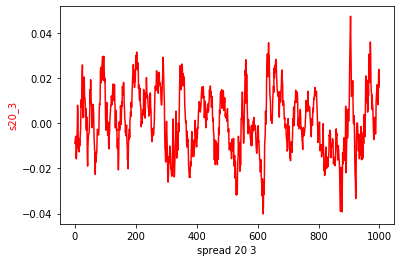

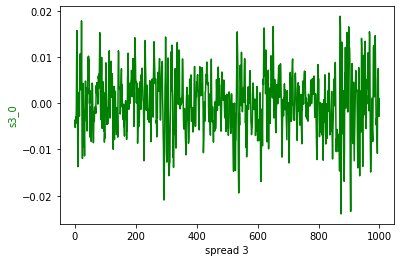

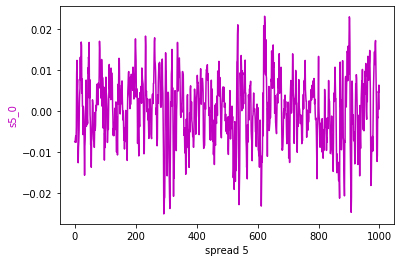

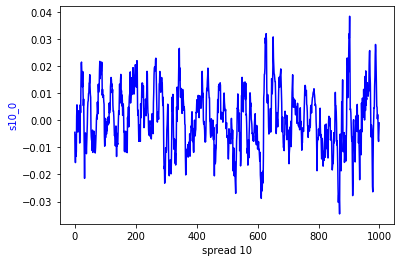

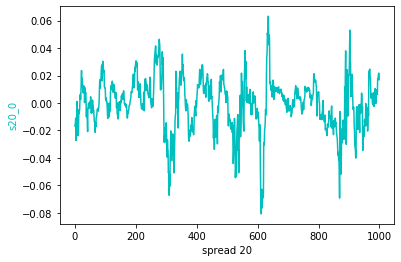

In [22]:
# spread feature only
s20_3 = spread_20_3[s1:s2]
s3_0 = spread_3_0[s1:s2]
s5_0 = spread_5_0[s1:s2]
s10_0 = spread_10_0[s1:s2]
s20_0 = spread_20_0[s1:s2]

'''
fig, ax = plt.subplots()
ax.plot(price, 'b-')
ax.set_xlabel('Price')
ax.set_ylabel('close', color='b')
plt.show()
'''

fig, ax = plt.subplots()
ax.plot(s20_3, 'r-')
ax.set_xlabel('spread 20 3')
ax.set_ylabel('s20_3', color='r')
plt.show()

fig, ax = plt.subplots()
ax.plot(s3_0, 'g-')
ax.set_xlabel('spread 3')
ax.set_ylabel('s3_0', color='g')
plt.show()

fig, ax = plt.subplots()
ax.plot(s5_0, 'm-')
ax.set_xlabel('spread 5')
ax.set_ylabel('s5_0', color='m')
plt.show()

fig, ax = plt.subplots()
ax.plot(s10_0, 'b-')
ax.set_xlabel('spread 10')
ax.set_ylabel('s10_0', color='b')
plt.show()

fig, ax = plt.subplots()
ax.plot(s20_0, 'c-')
ax.set_xlabel('spread 20')
ax.set_ylabel('s20_0', color='c')
plt.show()

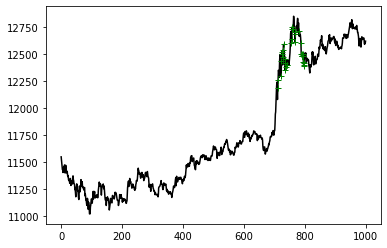

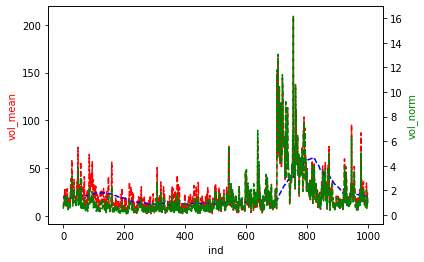

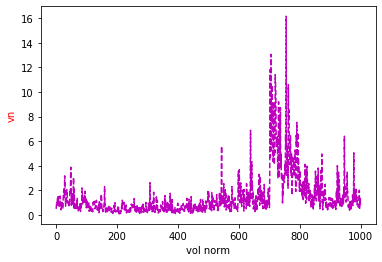

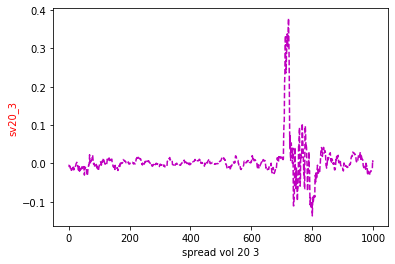

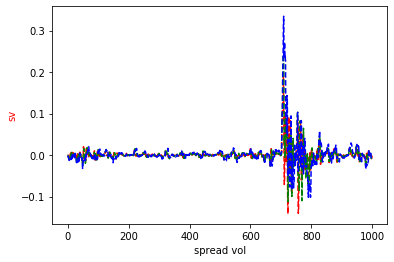

In [259]:
# detect price-bottom signal by kline spread-vol or spread feature
s1 = 27000
s2 = s1 + 1000

# spread vol feature 
sv20_3 = spread_vol_20_3[s1:s2]
sv3_0 = spread_vol_3_0[s1:s2]
sv5_0 = spread_vol_5_0[s1:s2]
sv10_0 = spread_vol_10_0[s1:s2]

vol = volume[s1:s2]
vol_mean = volume_mean[s1:s2]
vol_norm = volume_norm[s1:s2]
price = close_price[s1:s2]

#bottom_ind = (vol > 2.0 * vol_mean) & (sv3_0 < -0.05) & (sv5_0 < -0.05) & (sv10_0 < -0.05)
# a. large volume, b. large price slip c. low price in history
volume_ind = vol_norm > 1.5
price_slip_ind = (sv3_0 < -0.04) | (sv5_0 < -0.05) | (sv10_0 < -0.05)
total_price_vol = np.sum([price[i]/vol[i] for i in range(len(price))])
less_price_vol = np.sum([price[i]*vol[i] for i in range(len(price)) if price[i] < price[-1]]) 
price_ratio = less_price_vol / total_price_vol

bottom_ind = (vol_norm > 1.5) & ((sv3_0 < -0.04) | (sv5_0 < -0.05) | (sv10_0 < -0.05))
bottom_price = price[bottom_ind]

plt.plot(price, 'k-')
plt.plot(bottom_ind.nonzero()[0], bottom_price, 'g+')
plt.show()

fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.plot(vol, 'r--')
ax.plot(vol_mean, 'b--')
ax2.plot(vol_norm, 'g--')
#ax.plot(sv2, 'g-')
ax.set_xlabel('ind')
ax.set_ylabel('vol_mean', color='b')
ax2.set_xlabel('ind')
ax2.set_ylabel('vol_norm', color='g')
plt.show()

fig, ax = plt.subplots()
ax.plot(vol_norm, 'm--')
ax.set_xlabel('vol norm')
ax.set_ylabel('vn', color='r')
plt.show()

fig, ax = plt.subplots()
ax.plot(sv20_3, 'm--')
ax.set_xlabel('spread vol 20 3')
ax.set_ylabel('sv20_3', color='m')
plt.show()

fig, ax = plt.subplots()
ax.plot(sv3_0, 'r--')
ax.plot(sv5_0, 'g--')
ax.plot(sv10_0, 'b--')
ax.set_xlabel('spread vol')
ax.set_ylabel('sv', color='r')
plt.show()

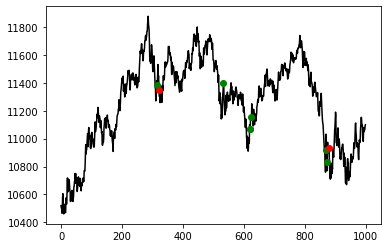

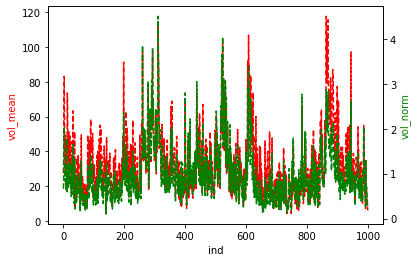

In [243]:
bottom_ind = (vol > 2.0 * vol_mean) & (sv3_0 < -0.05) & (sv5_0 < -0.05) & (sv10_0 < -0.05)
bottom_price = price[bottom_ind]

reb_ind = (sv20_3 < -0.05) & (sv3_0 > 0.02)
reb_spread_ind = (s20_3 < -0.05) & (s3_0 > 0.02)
reb_price = price[reb_ind]
reb_spread_price = price[reb_spread_ind]

fall_ind = (sv10_0 > 0.03) & (sv3_0 < -0.01)
fall_spread_ind = (s10_0 > 0.03) & (s3_0 < -0.01)
fall_price = price[fall_ind]
fall_spread_price = price[fall_spread_ind]

take_profit_price = 1.03*bottom_price

plt.plot(price, 'k-')
plt.plot(reb_ind.nonzero()[0], reb_price, 'go')
plt.plot(reb_spread_ind.nonzero()[0], reb_spread_price, 'go')

plt.plot(fall_ind.nonzero()[0], fall_price, 'ro')
plt.plot(fall_spread_ind.nonzero()[0], fall_spread_price, 'ro')

plt.plot(bottom_ind.nonzero()[0], take_profit_price, 'r+')
plt.plot(bottom_ind.nonzero()[0], bottom_price, 'g+')
plt.show()

fig, ax = plt.subplots()
ax2 = ax.twinx()
#ax.plot(reb_ind.nonzero()[0], reb_price, 'go')
#ax.plot(reb_ind.nonzero()[0], take_profit_price, 'ro')
#ax.plot(cover_ind.nonzero()[0], cover_price, 'g+')
ax.plot(vol, 'r--')
ax2.plot(vol_norm, 'g--')
#ax.plot(sv2, 'g-')

ax.set_xlabel('ind')
ax.set_ylabel('vol_mean', color='r')
ax2.set_xlabel('ind')
ax2.set_ylabel('vol_norm', color='g')
plt.show()

0.16


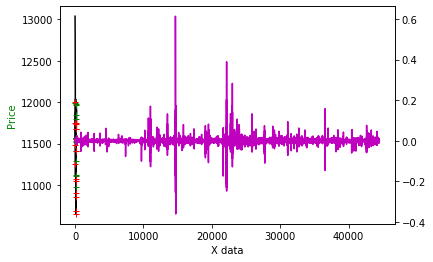

In [187]:
#s1, s2= 14600, 14900
#s1, s2= 10800, 11200
#s1, s2= 0, 44000
s1, s2= 22100, 22300
X = datasets[0]
#X = data_kline_group_feat[25000:30000, :]
y_pred = clf.predict(X[s1:s2,:])
vol_mean = volume_mean[s1:s2]
vol = volume[s1:s2]


#spread_vol_sum = spread_vol_cumsum[np.max(0:n, 0)] - spread
#svol = spread_vol[s1:s2]

price = close_price[s1:s2]
green_ind = (y_pred==-1) & (close_price[s1: s2] > 1.01*open_price[s1: s2])
red_ind = (y_pred==-1) & (close_price[s1: s2] < 0.99*open_price[s1: s2])
print((len(red_ind.nonzero()[0])+len(green_ind.nonzero()[0]))/ len(y_pred))

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(price, 'k-')
ax1.plot(green_ind.nonzero()[0], price[green_ind], 'g+')
ax1.plot(red_ind.nonzero()[0], price[red_ind], 'r+')
ax2.plot(spread_vol, 'm-')

ax1.set_xlabel('X data')
ax1.set_ylabel('Price', color='g')
#ax2.set_ylabel('AD', color='b')

plt.show()

#fig, ax3 = plt.subplots()
#ax3.plot(vol, 'm-')
#plt.show()

In [58]:
plt.plot(volume_mean, 'g-')
plt.show()

array([-0.00866627, -0.0012571 ,  0.00526175, ...,  0.0032818 ,
       -0.00128499, -0.00026783])